In [1]:
# Auto-reload modules when they change
%load_ext autoreload
%autoreload 2

In [7]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import transforms

# Local imports
from datasets import JunkFoodDataset
from qml.models.binary import BatchedGPUHybridQuantumCNN
from qml.ansatz import DenseQCNNAnsatz

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Load Dataset

In [4]:
# Configuration
train_data_folder = "data/data_aug"
test_data_folder = "data/data_noaug"

# Transform
IMAGE_SIZE = 128
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

# Load Datasets
train_dataset = JunkFoodDataset(train_data_folder, transform=transform)
full_test_dataset = JunkFoodDataset(test_data_folder, transform=transform)

# Determine size of test set to maintain ~80/20 ratio based on training size
# If Train is 80%, then Test should be 25% of Train size (since 20/80 = 1/4)
target_test_size = int(len(train_dataset) * 0.25)
print(f"Training count: {len(train_dataset)}")
print(f"Target Test count (for 80/20 ratio): {target_test_size}")

# Creates a random subset of the clean test data
indices = list(range(len(full_test_dataset)))
random.seed(42) # Ensure consistent test set
random.shuffle(indices)
test_dataset = Subset(full_test_dataset, indices[:target_test_size])

print(f"Actual Test count: {len(test_dataset)}")
print(f"Train/Test Ratio: {len(train_dataset)/(len(train_dataset)+len(test_dataset)):.2f}/{len(test_dataset)/(len(train_dataset)+len(test_dataset)):.2f}")

Training count: 4614
Target Test count (for 80/20 ratio): 1153
Actual Test count: 1153
Train/Test Ratio: 0.80/0.20


In [5]:
# Train/test configuration
BATCH_SIZE = 8
SEED = 42

# Create data loaders
torch.manual_seed(SEED)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training on {len(train_dataset)} augmented images, Testing on {len(test_dataset)} clean images.")

Training on 4614 augmented images, Testing on 1153 clean images.


## Create Quantum CNN Model

In [9]:
# Model configuration
model = BatchedGPUHybridQuantumCNN(
    kernel_size=12,
    stride=8,
    pool_size=8,
    encoding='dense',
    ansatz=DenseQCNNAnsatz(),
    measurement='x',
    hidden_size=128
)

model = model.to(device)

Using lightning.qubit device with 'dense' encoding, DenseQCNNAnsatz, measurement=PauliX
Using default.qubit device with 'dense' encoding, DenseQCNNAnsatz, measurement=PauliX


## Setup Training

In [11]:
from notebooks.trainer import Trainer

# Training configuration
LEARNING_RATE = 0.005
EPOCHS = 15

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# Create trainer
trainer = Trainer(
    criterion=criterion,
    device=device,
    max_grad_norm=1.0,
    log_interval=10
)

## Train Model
With test evaluation after each epoch

In [12]:
results = trainer.train(
    model=model,
    train_loader=train_loader,
    optimizer=optimizer,
    epochs=EPOCHS,
    test_loader=test_loader
)

Evaluating: 100%|██████████| 145/145 [00:37<00:00,  3.90it/s]


Epoch 1: Train Loss=0.6464, Train Acc=0.6495 | Test Loss=0.6012, Test Acc=0.6670


Evaluating: 100%|██████████| 145/145 [00:18<00:00,  7.76it/s]


Epoch 2: Train Loss=0.5999, Train Acc=0.6764 | Test Loss=0.5693, Test Acc=0.7060


Evaluating: 100%|██████████| 145/145 [00:19<00:00,  7.54it/s]


Epoch 3: Train Loss=0.5789, Train Acc=0.6974 | Test Loss=0.5700, Test Acc=0.6904


Evaluating: 100%|██████████| 145/145 [00:18<00:00,  7.72it/s]


Epoch 4: Train Loss=0.5586, Train Acc=0.7068 | Test Loss=0.5467, Test Acc=0.7372


Evaluating: 100%|██████████| 145/145 [00:18<00:00,  7.74it/s]


Epoch 5: Train Loss=0.5393, Train Acc=0.7230 | Test Loss=0.5004, Test Acc=0.7485


Evaluating: 100%|██████████| 145/145 [00:19<00:00,  7.30it/s]


Epoch 6: Train Loss=0.5184, Train Acc=0.7369 | Test Loss=0.4860, Test Acc=0.7710


Evaluating: 100%|██████████| 145/145 [00:19<00:00,  7.40it/s]


Epoch 7: Train Loss=0.5116, Train Acc=0.7475 | Test Loss=0.4774, Test Acc=0.7589


Evaluating: 100%|██████████| 145/145 [00:19<00:00,  7.58it/s]


Epoch 8: Train Loss=0.5009, Train Acc=0.7518 | Test Loss=0.4642, Test Acc=0.7650


Evaluating: 100%|██████████| 145/145 [00:20<00:00,  7.03it/s]


Epoch 9: Train Loss=0.4825, Train Acc=0.7692 | Test Loss=0.4681, Test Acc=0.7684


Evaluating: 100%|██████████| 145/145 [00:19<00:00,  7.43it/s]


Epoch 10: Train Loss=0.4699, Train Acc=0.7731 | Test Loss=0.4451, Test Acc=0.7979


Evaluating: 100%|██████████| 145/145 [00:19<00:00,  7.46it/s]


Epoch 11: Train Loss=0.4573, Train Acc=0.7854 | Test Loss=0.4325, Test Acc=0.7944


Evaluating: 100%|██████████| 145/145 [00:20<00:00,  7.12it/s]


Epoch 12: Train Loss=0.4514, Train Acc=0.7948 | Test Loss=0.4047, Test Acc=0.8066


Evaluating: 100%|██████████| 145/145 [00:22<00:00,  6.43it/s]


Epoch 13: Train Loss=0.4335, Train Acc=0.7967 | Test Loss=0.4091, Test Acc=0.8135


Evaluating: 100%|██████████| 145/145 [00:20<00:00,  6.94it/s]


Epoch 14: Train Loss=0.4307, Train Acc=0.8097 | Test Loss=0.4044, Test Acc=0.8291


Evaluating: 100%|██████████| 145/145 [00:22<00:00,  6.46it/s]

Epoch 15: Train Loss=0.4275, Train Acc=0.8104 | Test Loss=0.3781, Test Acc=0.8369


## Train results

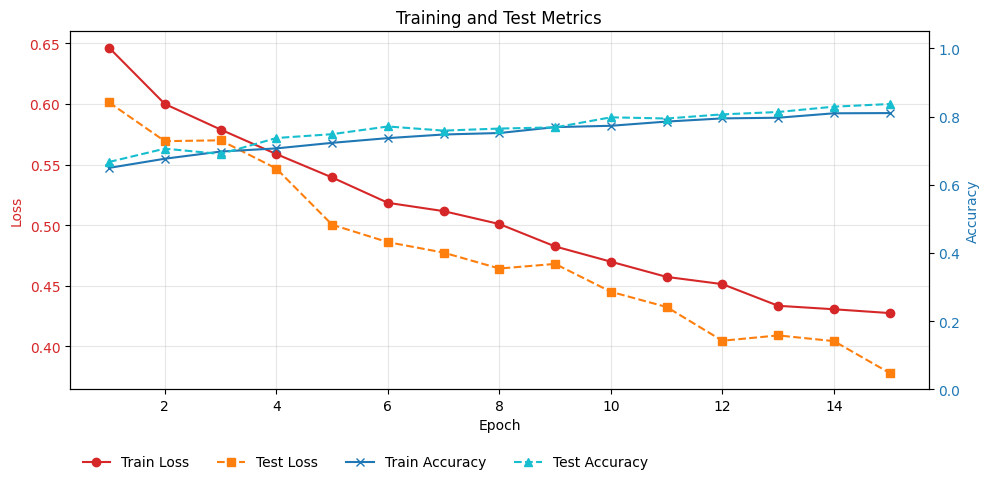

In [13]:
from notebooks.utils import plot_loss_and_accuracy

plot_loss_and_accuracy(
    losses=results['train_loss'],
    accuracies=results['train_acc'],
    test_losses=results['test_loss'],
    test_accuracies=results['test_acc']
)

Evaluating: 100%|██████████| 145/145 [00:18<00:00,  7.81it/s]



Final Test Results:
Test Loss: 0.3781
Test Accuracy: 0.8369


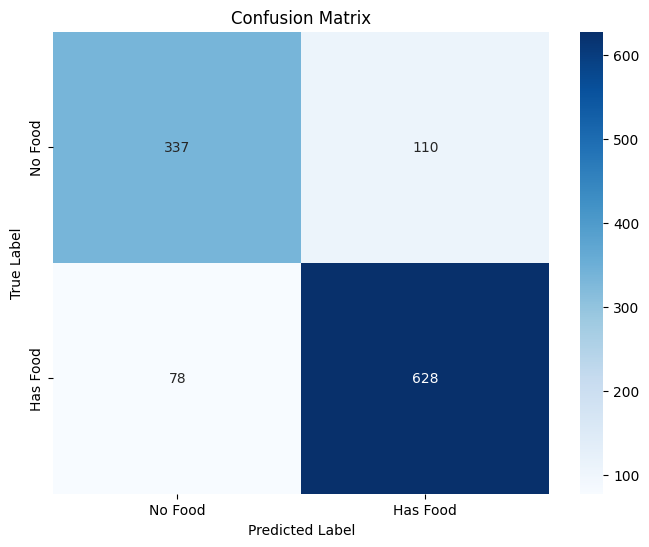


Detailed Metrics:
Precision: 0.8509
Recall: 0.8895
F1 Score: 0.8698

Confusion Matrix:
True Negatives:  337
False Positives: 110
False Negatives: 78
True Positives:  628


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate on test set
(test_loss, test_acc), confusion_matrix = trainer.evaluate(model, test_loader)

print(f"\nFinal Test Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Food', 'Has Food'], 
            yticklabels=['No Food', 'Has Food'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Print detailed metrics
tn, fp, fn, tp = confusion_matrix.ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nDetailed Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"\nConfusion Matrix:")
print(f"True Negatives:  {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives:  {tp}")